In [36]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest #feature selection
from sklearn.feature_selection import chi2
from sklearn.utils import resample #re-sampling
from sklearn.model_selection import train_test_split #data splitting
from sklearn.preprocessing import StandardScaler #normalize features

from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.naive_bayes import GaussianNB #gaussian naive bayes
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #decision tree
from sklearn.ensemble import RandomForestClassifier #random forest
from sklearn.neighbors import KNeighborsClassifier #k-nearest neighbor
from sklearn.neural_network import MLPClassifier #neural network
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import roc_auc_score #roc score

In [37]:
# LOAD THE DATA
application_train = pd.read_csv("sample_data/application_train.csv")

In [38]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
     

missing_data(application_train).head(10)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


In [40]:
train = application_train.copy()

In [41]:
decode_map = {0: "No Payment Difficulties", 1: "Payment Difficulties"}
def decode_sentiment(label):
    return decode_map[int(label)]

train['TARGET'] = train['TARGET'].apply(lambda x: decode_sentiment(x))

In [42]:
target_grp = (train[['TARGET']]
                .groupby("TARGET")
                .agg(COUNT=("TARGET","count"))
                .sort_values(by=["COUNT"],ascending=False)
                .reset_index()
                )

target_grp.style.background_gradient(cmap='Blues')

,TARGET,COUNT
0,No Payment Difficulties,282686
1,Payment Difficulties,24825


In [43]:
grp = train['TARGET'].value_counts(normalize=True)
grp.reset_index().style.background_gradient(cmap='Blues')

,index,TARGET
0,No Payment Difficulties,0.919271
1,Payment Difficulties,0.080729


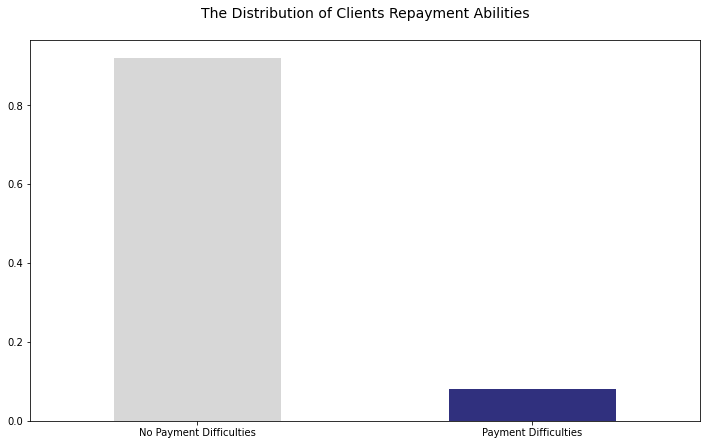

In [44]:
fig = plt.figure(figsize = (12,7))
grp.plot(kind='bar', color= ['lightgrey','midnightblue'], alpha = 0.9, rot=0)
plt.title('The Distribution of Clients Repayment Abilities\n', fontsize=14)
plt.show()

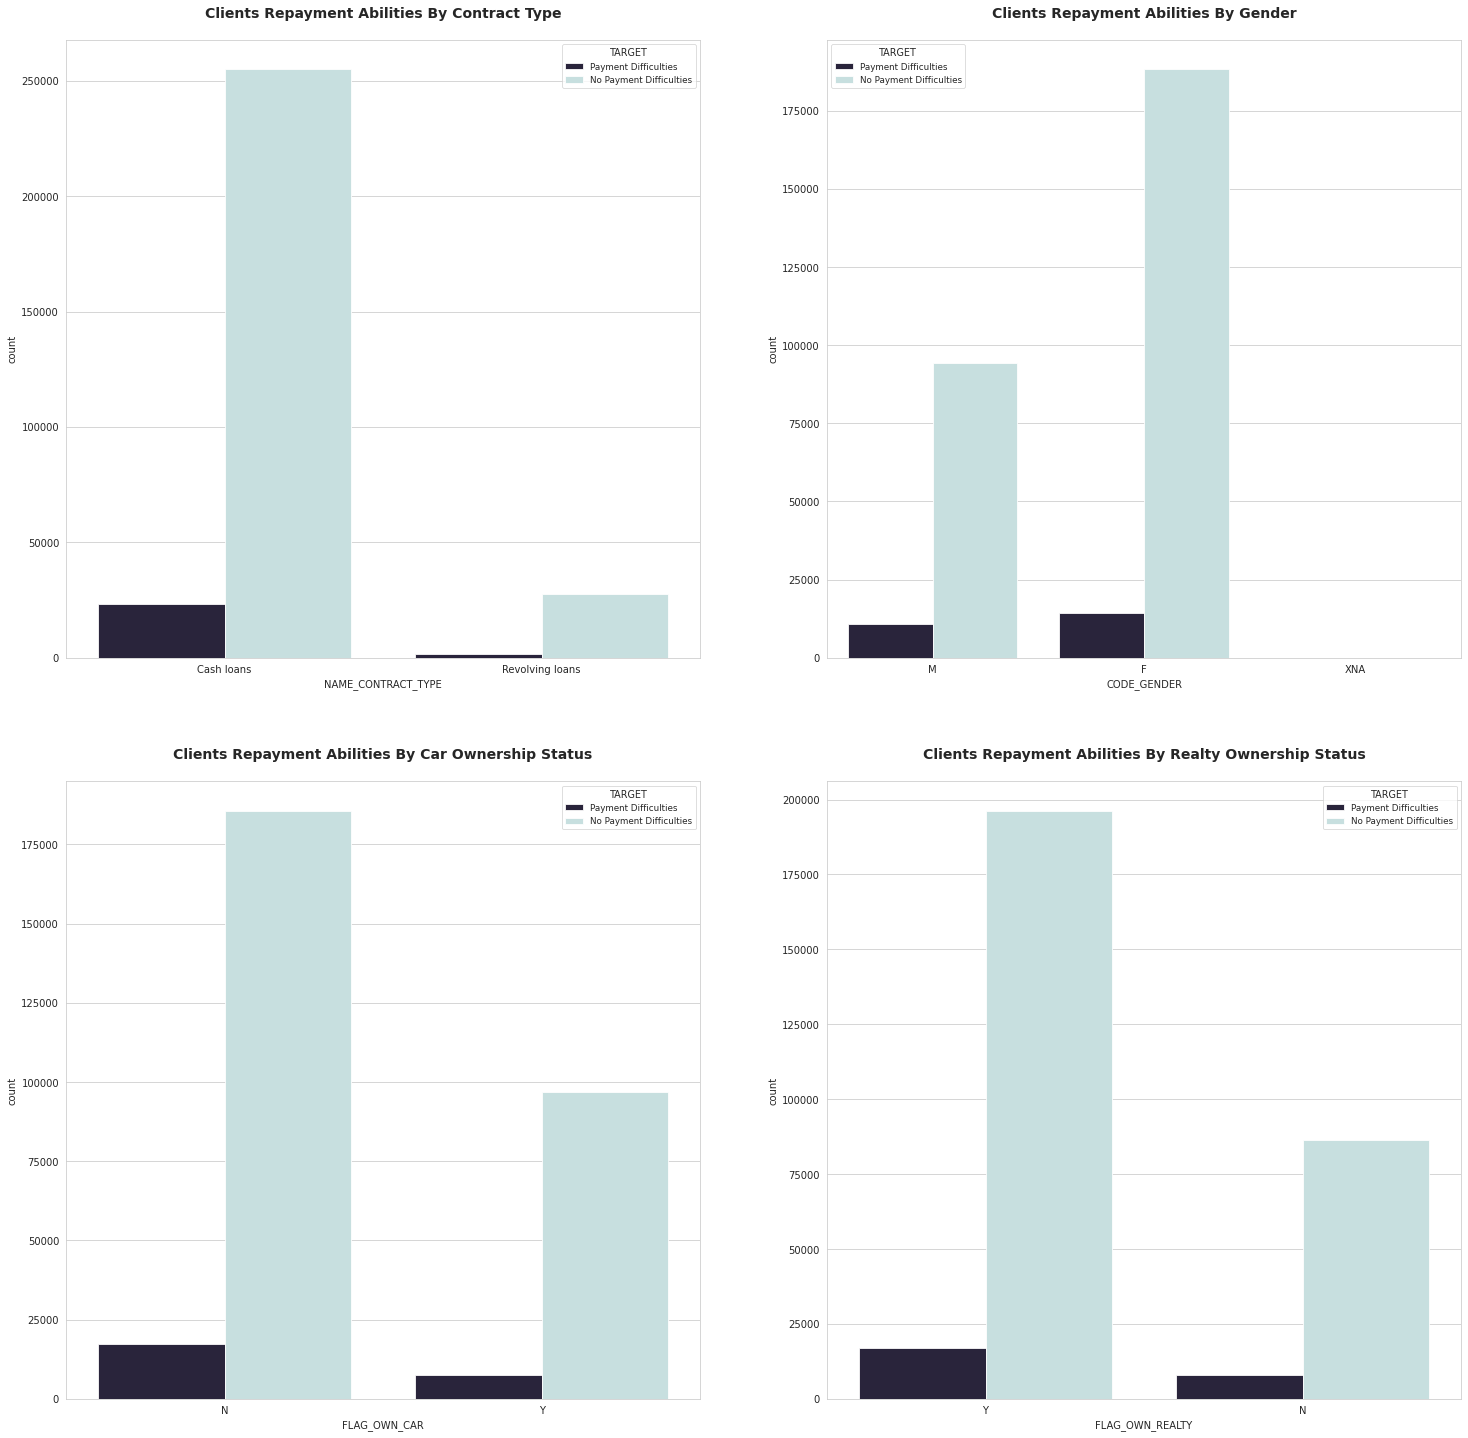

In [45]:
# visualization pt 1
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(25,25))
sns.set_context('paper', font_scale=1)

ax[0][0].set_title('Clients Repayment Abilities By Contract Type\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_CONTRACT_TYPE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][0])

ax[0][1].set_title('Clients Repayment Abilities By Gender\n', fontweight='bold', fontsize=14)
sns.countplot(x='CODE_GENDER', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][1])

ax[1][0].set_title('\nClients Repayment Abilities By Car Ownership Status\n', fontweight='bold', fontsize=14)
sns.countplot(x='FLAG_OWN_CAR', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][0])

ax[1][1].set_title('\nClients Repayment Abilities By Realty Ownership Status\n', fontweight='bold', fontsize=14)
sns.countplot(x='FLAG_OWN_REALTY', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][1])

In [46]:
ct = train.groupby(by=['NAME_CONTRACT_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Contract Type')
ct.sort_values(by='SK_ID_CURR', ascending=False)
ct.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Contract Type


,NAME_CONTRACT_TYPE,TARGET,SK_ID_CURR
0,Cash loans,No Payment Difficulties,255011
1,Cash loans,Payment Difficulties,23221
2,Revolving loans,No Payment Difficulties,27675
3,Revolving loans,Payment Difficulties,1604


In [47]:
#target vs gender
train['CODE_GENDER'] = train['CODE_GENDER'].replace(['F','M'],['Female','Male'])


In [48]:
gt = train.groupby(by=['CODE_GENDER','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Gender')
gt.sort_values(by='SK_ID_CURR', ascending=False)
gt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Gender


,CODE_GENDER,TARGET,SK_ID_CURR
0,Female,No Payment Difficulties,188278
1,Female,Payment Difficulties,14170
2,Male,No Payment Difficulties,94404
3,Male,Payment Difficulties,10655
4,XNA,No Payment Difficulties,4


In [50]:
application_train[['CODE_GENDER','TARGET']].groupby(['CODE_GENDER'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,CODE_GENDER,TARGET
1,M,0.101419
0,F,0.069993
2,XNA,0.000000


In [ ]:
#Car Ownership Status Vs Target

In [51]:
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].replace(['Y','N'],['Yes','No'])

In [52]:
ot = train.groupby(by=['FLAG_OWN_CAR','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Car Ownership Status')
ot.sort_values(by='SK_ID_CURR', ascending=False)
ot.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Car Ownership Status


,FLAG_OWN_CAR,TARGET,SK_ID_CURR
0,No,No Payment Difficulties,185675
1,No,Payment Difficulties,17249
2,Yes,No Payment Difficulties,97011
3,Yes,Payment Difficulties,7576


In [54]:
application_train[['FLAG_OWN_CAR','TARGET']].groupby(['FLAG_OWN_CAR'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FLAG_OWN_CAR,TARGET
0,N,0.085002
1,Y,0.072437


In [55]:
#status vs target
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].replace(['Y','N'],['Yes','No'])

In [56]:
rt = train.groupby(by=['FLAG_OWN_REALTY','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Realty Ownership Status')
rt.sort_values(by='SK_ID_CURR', ascending=False)
rt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Realty Ownership Status


,FLAG_OWN_REALTY,TARGET,SK_ID_CURR
0,No,No Payment Difficulties,86357
1,No,Payment Difficulties,7842
2,Yes,No Payment Difficulties,196329
3,Yes,Payment Difficulties,16983


In [57]:
application_train[['FLAG_OWN_REALTY','TARGET']].groupby(['FLAG_OWN_REALTY'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FLAG_OWN_REALTY,TARGET
0,N,0.083249
1,Y,0.079616


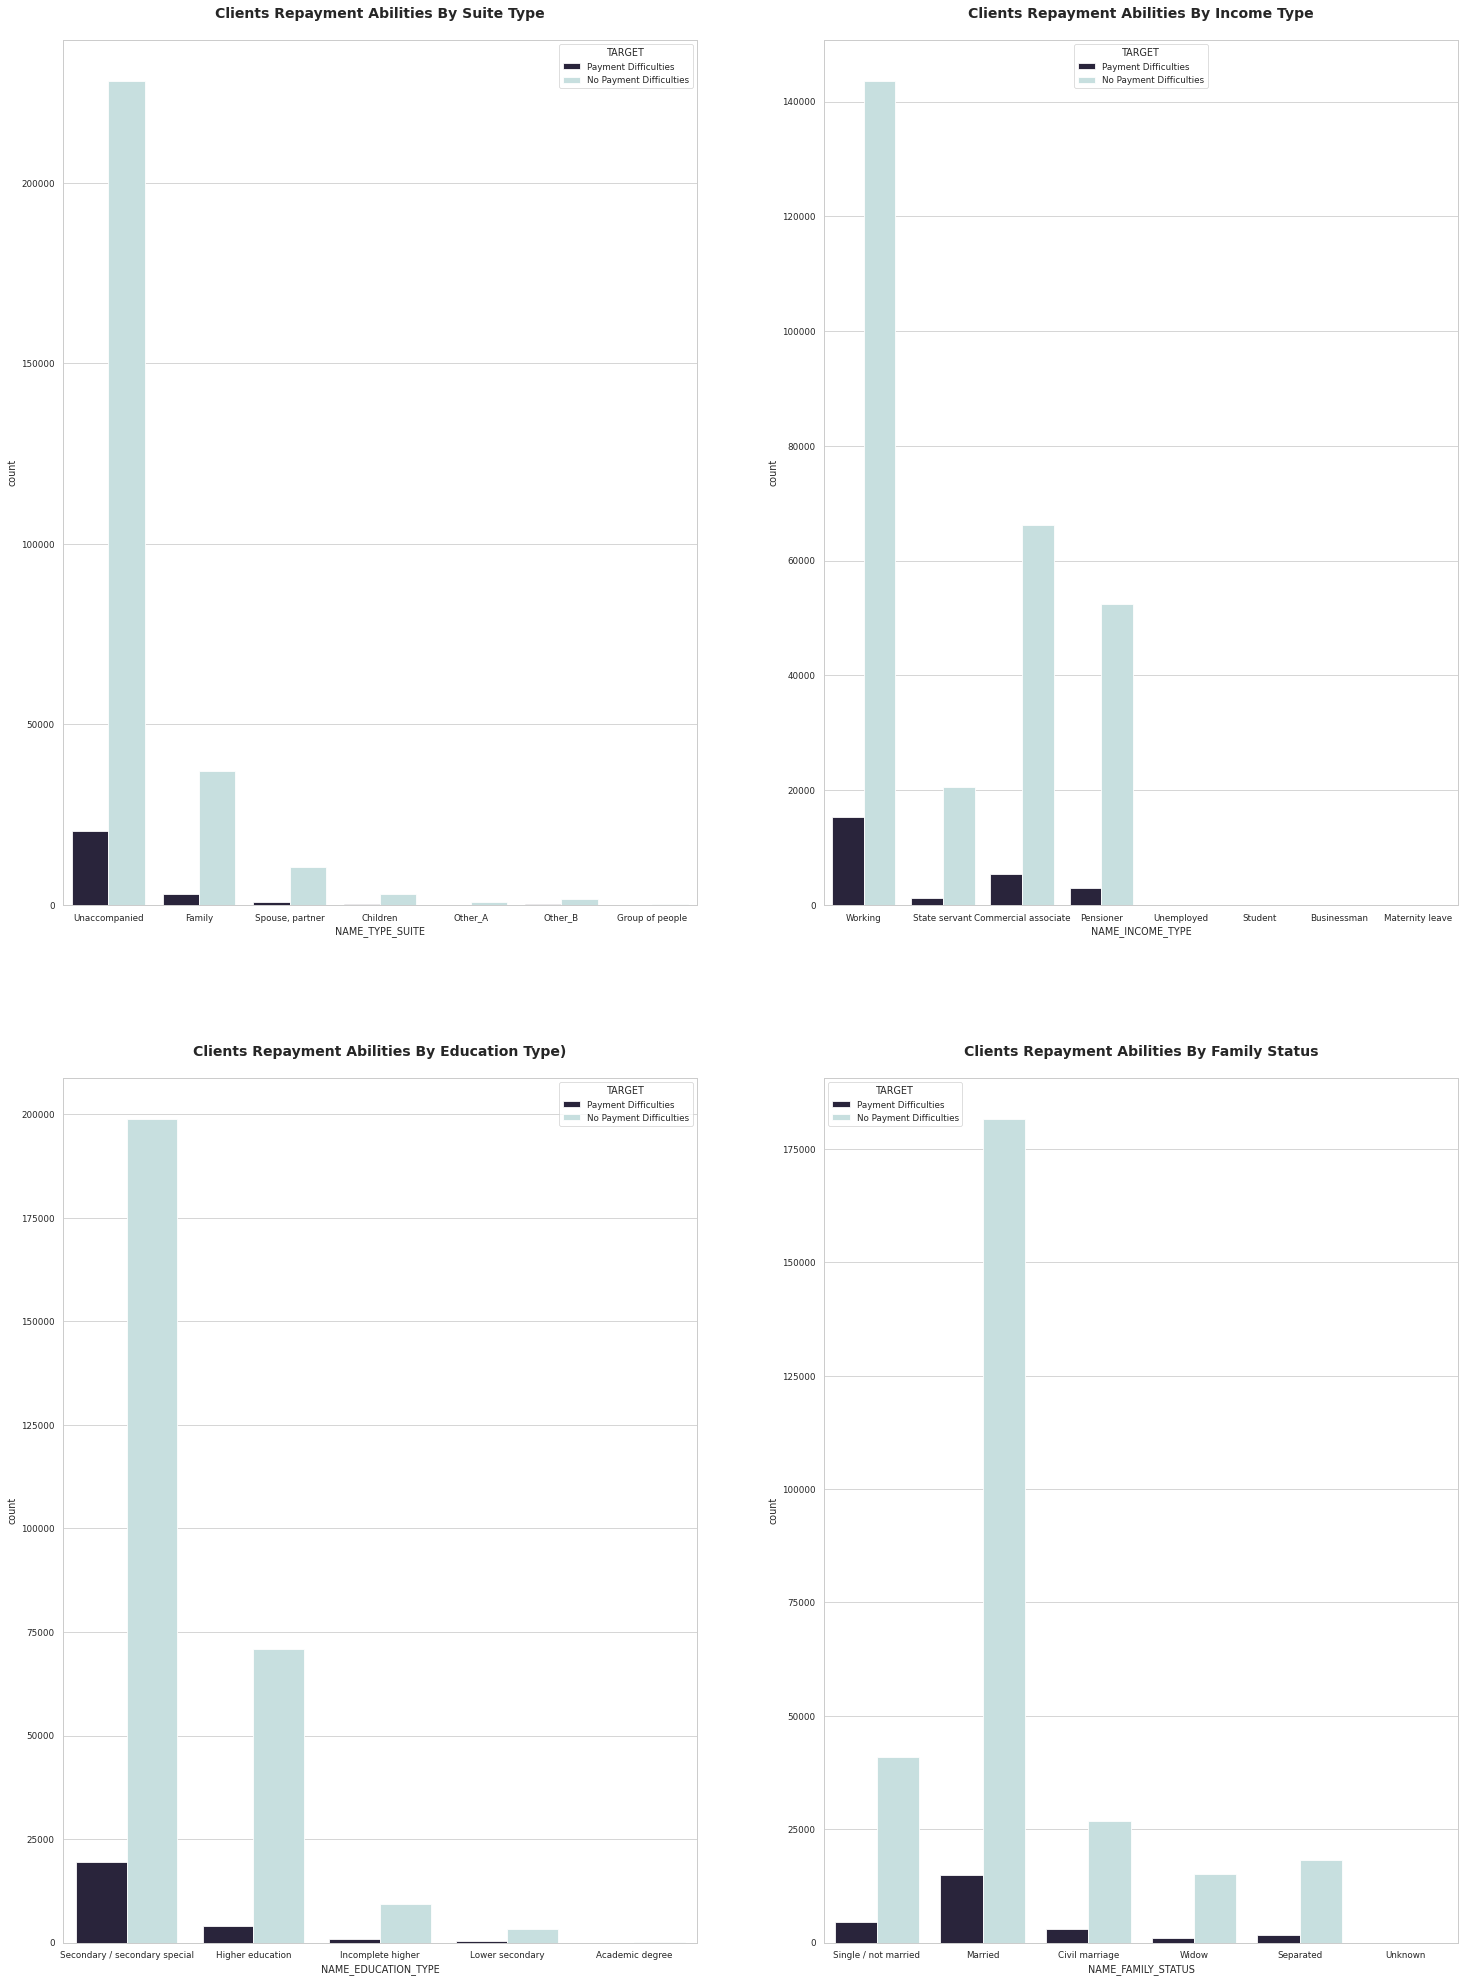

In [58]:
# visualization pt. 2
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(25,35))
sns.set_context('paper', font_scale=1)

ax[0][0].set_title('Clients Repayment Abilities By Suite Type\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_TYPE_SUITE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][0])

ax[0][1].set_title('Clients Repayment Abilities By Income Type\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_INCOME_TYPE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][1])

ax[1][0].set_title('\nClients Repayment Abilities By Education Type)\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_EDUCATION_TYPE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][0])

ax[1][1].set_title('\nClients Repayment Abilities By Family Status\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_FAMILY_STATUS', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][1])

In [59]:
#suite vs target

st = train.groupby(by=['NAME_TYPE_SUITE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Suite Type')
st.sort_values(by='SK_ID_CURR', ascending=False)
st.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Suite Type


,NAME_TYPE_SUITE,TARGET,SK_ID_CURR
0,Children,No Payment Difficulties,3026
1,Children,Payment Difficulties,241
2,Family,No Payment Difficulties,37140
3,Family,Payment Difficulties,3009
4,Group of people,No Payment Difficulties,248
5,Group of people,Payment Difficulties,23
6,Other_A,No Payment Difficulties,790
7,Other_A,Payment Difficulties,76
8,Other_B,No Payment Difficulties,1596
9,Other_B,Payment Difficulties,174


In [60]:
application_train[['NAME_TYPE_SUITE','TARGET']].groupby(['NAME_TYPE_SUITE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_TYPE_SUITE,TARGET
4,Other_B,0.098305
3,Other_A,0.087760
2,Group of people,0.084871
6,Unaccompanied,0.081830
5,"Spouse, partner",0.078716
1,Family,0.074946
0,Children,0.073768


In [ ]:
#income vs target

In [61]:
rt = train.groupby(by=['NAME_INCOME_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Income Type')
rt.sort_values(by='SK_ID_CURR', ascending=False)
rt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Income Type


,NAME_INCOME_TYPE,TARGET,SK_ID_CURR
0,Businessman,No Payment Difficulties,10
1,Commercial associate,No Payment Difficulties,66257
2,Commercial associate,Payment Difficulties,5360
3,Maternity leave,No Payment Difficulties,3
4,Maternity leave,Payment Difficulties,2
5,Pensioner,No Payment Difficulties,52380
6,Pensioner,Payment Difficulties,2982
7,State servant,No Payment Difficulties,20454
8,State servant,Payment Difficulties,1249
9,Student,No Payment Difficulties,18


In [62]:
application_train[['NAME_INCOME_TYPE','TARGET']].groupby(['NAME_INCOME_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_INCOME_TYPE,TARGET
2,Maternity leave,0.400000
6,Unemployed,0.363636
7,Working,0.095885
1,Commercial associate,0.074843
4,State servant,0.057550
3,Pensioner,0.053864
0,Businessman,0.000000
5,Student,0.000000


In [63]:
#Education Vs Target

et = train.groupby(by=['NAME_EDUCATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Education Type')
et.sort_values(by='SK_ID_CURR', ascending=False)
et.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Education Type


,NAME_EDUCATION_TYPE,TARGET,SK_ID_CURR
0,Academic degree,No Payment Difficulties,161
1,Academic degree,Payment Difficulties,3
2,Higher education,No Payment Difficulties,70854
3,Higher education,Payment Difficulties,4009
4,Incomplete higher,No Payment Difficulties,9405
5,Incomplete higher,Payment Difficulties,872
6,Lower secondary,No Payment Difficulties,3399
7,Lower secondary,Payment Difficulties,417
8,Secondary / secondary special,No Payment Difficulties,198867
9,Secondary / secondary special,Payment Difficulties,19524


In [64]:
application_train[['NAME_EDUCATION_TYPE','TARGET']].groupby(['NAME_EDUCATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_EDUCATION_TYPE,TARGET
3,Lower secondary,0.109277
4,Secondary / secondary special,0.089399
2,Incomplete higher,0.084850
1,Higher education,0.053551
0,Academic degree,0.018293


In [65]:
#Family Status Vs Target
ft = train.groupby(by=['NAME_FAMILY_STATUS','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Family Status')
ft.sort_values(by='SK_ID_CURR', ascending=False)
ft.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Family Status


,NAME_FAMILY_STATUS,TARGET,SK_ID_CURR
0,Civil marriage,No Payment Difficulties,26814
1,Civil marriage,Payment Difficulties,2961
2,Married,No Payment Difficulties,181582
3,Married,Payment Difficulties,14850
4,Separated,No Payment Difficulties,18150
5,Separated,Payment Difficulties,1620
6,Single / not married,No Payment Difficulties,40987
7,Single / not married,Payment Difficulties,4457
8,Unknown,No Payment Difficulties,2
9,Widow,No Payment Difficulties,15151


In [66]:
application_train[['NAME_FAMILY_STATUS','TARGET']].groupby(['NAME_FAMILY_STATUS'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_FAMILY_STATUS,TARGET
0,Civil marriage,0.099446
3,Single / not married,0.098077
2,Separated,0.081942
1,Married,0.075599
5,Widow,0.058242
4,Unknown,0.000000


In [67]:
#house vs target
ht = train.groupby(by=['NAME_HOUSING_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Housing Type')
ht.sort_values(by='SK_ID_CURR', ascending=False)
ht.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Housing Type


,NAME_HOUSING_TYPE,TARGET,SK_ID_CURR
0,Co-op apartment,No Payment Difficulties,1033
1,Co-op apartment,Payment Difficulties,89
2,House / apartment,No Payment Difficulties,251596
3,House / apartment,Payment Difficulties,21272
4,Municipal apartment,No Payment Difficulties,10228
5,Municipal apartment,Payment Difficulties,955
6,Office apartment,No Payment Difficulties,2445
7,Office apartment,Payment Difficulties,172
8,Rented apartment,No Payment Difficulties,4280
9,Rented apartment,Payment Difficulties,601


In [68]:
application_train[['NAME_HOUSING_TYPE','TARGET']].groupby(['NAME_HOUSING_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_HOUSING_TYPE,TARGET
4,Rented apartment,0.123131
5,With parents,0.116981
2,Municipal apartment,0.085397
0,Co-op apartment,0.079323
1,House / apartment,0.077957
3,Office apartment,0.065724


Text(0.5, 0, '\nHousing Type')

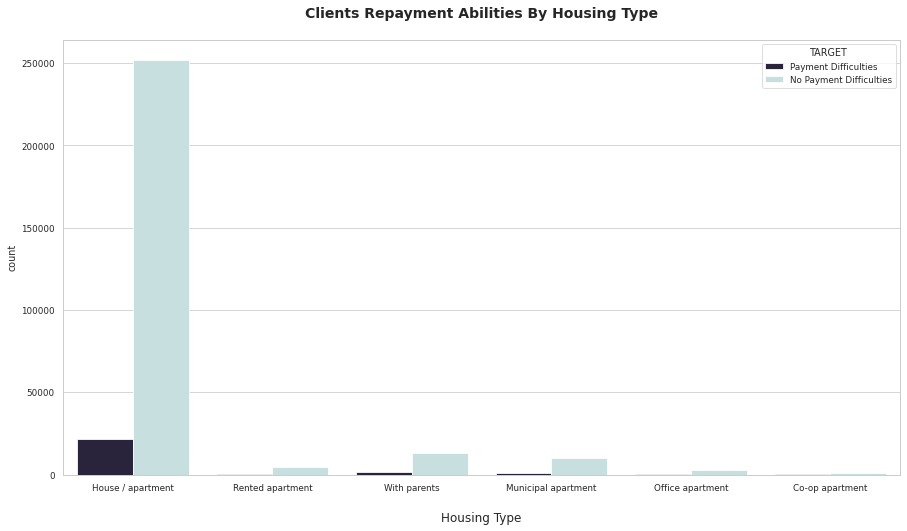

In [69]:
# visualization
plt.figure(figsize=(15,8))
fig = sns.countplot(x='NAME_HOUSING_TYPE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r')
plt.title('Clients Repayment Abilities By Housing Type\n', fontweight='bold', fontsize=14)
plt.xlabel('\nHousing Type', fontsize=12)

In [70]:
#Occupation Type Vs Target
ot = train.groupby(by=['OCCUPATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Occupation Type')
ot.sort_values(by='SK_ID_CURR', ascending=False)
ot.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Occupation Type


,OCCUPATION_TYPE,TARGET,SK_ID_CURR
0,Accountants,No Payment Difficulties,9339
1,Accountants,Payment Difficulties,474
2,Cleaning staff,No Payment Difficulties,4206
3,Cleaning staff,Payment Difficulties,447
4,Cooking staff,No Payment Difficulties,5325
5,Cooking staff,Payment Difficulties,621
6,Core staff,No Payment Difficulties,25832
7,Core staff,Payment Difficulties,1738
8,Drivers,No Payment Difficulties,16496
9,Drivers,Payment Difficulties,2107


In [71]:
application_train[['OCCUPATION_TYPE','TARGET']].groupby(['OCCUPATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,OCCUPATION_TYPE,TARGET
9,Low-skill Laborers,0.171524
4,Drivers,0.113261
17,Waiters/barmen staff,0.112760
16,Security staff,0.107424
8,Laborers,0.105788
2,Cooking staff,0.104440
14,Sales staff,0.096318
1,Cleaning staff,0.096067
13,Realty agents,0.078562
15,Secretaries,0.070498


In [72]:
#Day Vs Target
pt = train.groupby(by=['WEEKDAY_APPR_PROCESS_START','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Process Day')
pt.sort_values(by='SK_ID_CURR', ascending=False)
pt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Process Day


,WEEKDAY_APPR_PROCESS_START,TARGET,SK_ID_CURR
0,FRIDAY,No Payment Difficulties,46237
1,FRIDAY,Payment Difficulties,4101
2,MONDAY,No Payment Difficulties,46780
3,MONDAY,Payment Difficulties,3934
4,SATURDAY,No Payment Difficulties,31182
5,SATURDAY,Payment Difficulties,2670
6,SUNDAY,No Payment Difficulties,14898
7,SUNDAY,Payment Difficulties,1283
8,THURSDAY,No Payment Difficulties,46493
9,THURSDAY,Payment Difficulties,4098


In [76]:
application_train[['WEEKDAY_APPR_PROCESS_START','TARGET']].groupby(['WEEKDAY_APPR_PROCESS_START'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,WEEKDAY_APPR_PROCESS_START,TARGET
5,TUESDAY,0.083505
6,WEDNESDAY,0.081604
0,FRIDAY,0.081469
4,THURSDAY,0.081003
3,SUNDAY,0.079291
2,SATURDAY,0.078873
1,MONDAY,0.077572


Text(0.5, 0, '\nProcess Day')

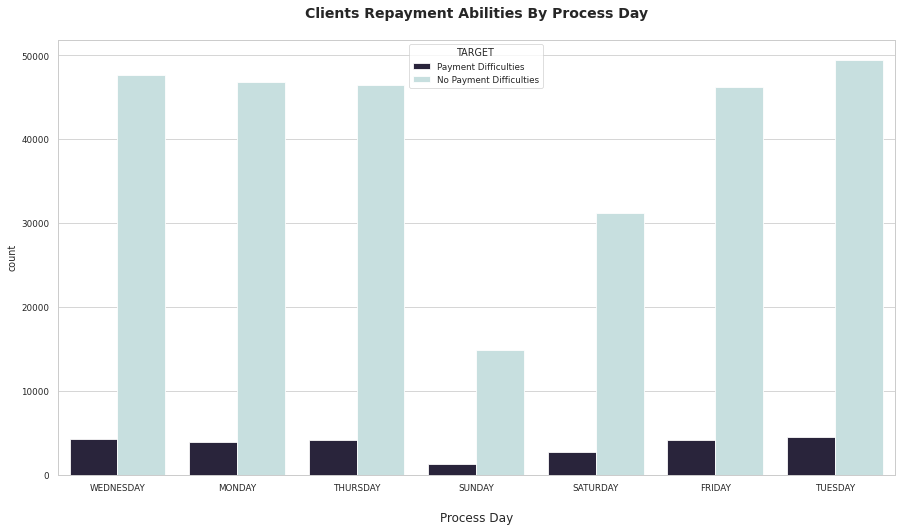

In [77]:

# visualization
plt.figure(figsize=(15,8))
fig = sns.countplot(x='WEEKDAY_APPR_PROCESS_START', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r')
plt.title('Clients Repayment Abilities By Process Day\n', fontweight='bold', fontsize=14)
plt.xlabel('\nProcess Day', fontsize=12)

In [78]:
#Organization Type Vs Target

tt = train.groupby(by=['ORGANIZATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Suite Type')
tt.sort_values(by='SK_ID_CURR', ascending=False)
tt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Suite Type


,ORGANIZATION_TYPE,TARGET,SK_ID_CURR
0,Advertising,No Payment Difficulties,394
1,Advertising,Payment Difficulties,35
2,Agriculture,No Payment Difficulties,2197
3,Agriculture,Payment Difficulties,257
4,Bank,No Payment Difficulties,2377
5,Bank,Payment Difficulties,130
6,Business Entity Type 1,No Payment Difficulties,5497
7,Business Entity Type 1,Payment Difficulties,487
8,Business Entity Type 2,No Payment Difficulties,9653
9,Business Entity Type 2,Payment Difficulties,900


In [80]:
application_train[['ORGANIZATION_TYPE','TARGET']].groupby(['ORGANIZATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)


,ORGANIZATION_TYPE,TARGET
54,Transport: type 3,0.157540
18,Industry: type 13,0.134328
25,Industry: type 8,0.125000
38,Restaurant,0.117062
7,Construction,0.116798
6,Cleaning,0.111538
14,Industry: type 1,0.110683
20,Industry: type 3,0.106162
36,Realtor,0.106061
1,Agriculture,0.104727


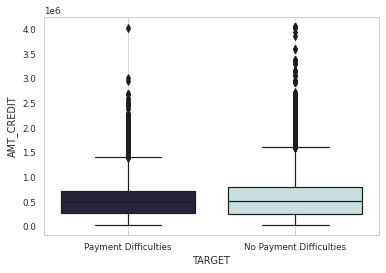

In [81]:
#Bivariate: Numerical Features Vs Target
#Amount Credit of the Loan Vs Target
sns.boxplot(x='TARGET', y='AMT_CREDIT', data=train, palette = 'ch:start=0.2,rot=-.3_r')
plt.grid()
plt.show()


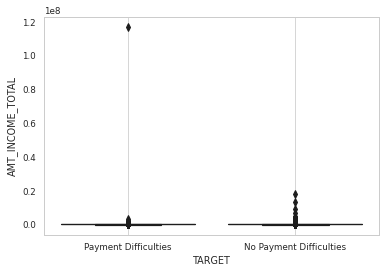

In [82]:
#Amount Income Vs Target
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=train, palette = 'ch:start=0.2,rot=-.3_r')
plt.grid()
plt.show()

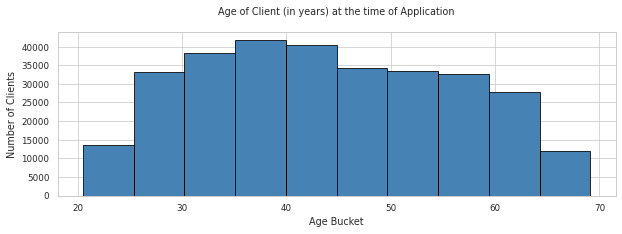

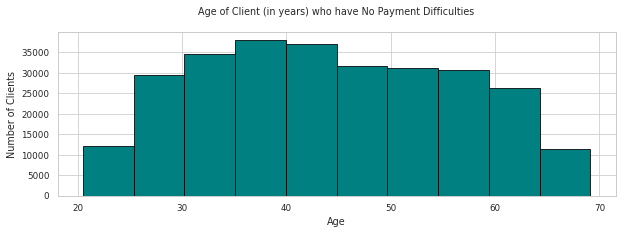

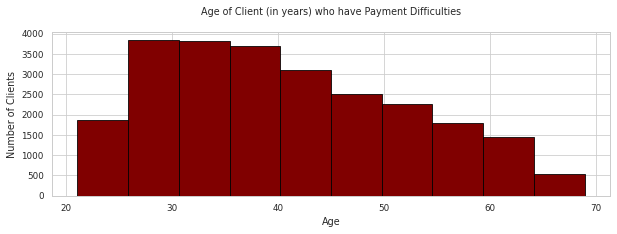

In [84]:
#Age Vs target
no_age = application_train[application_train['TARGET']==0]['DAYS_BIRTH'].values/-365
yes_age = application_train[application_train['TARGET']==1]['DAYS_BIRTH'].values/-365
plt.figure(figsize=(10,3))
plt.hist(application_train['DAYS_BIRTH'].values/-365, bins=10, edgecolor='black', color='steelblue')
plt.title('Age of Client (in years) at the time of Application\n')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(no_age, bins=10, edgecolor='black', color='teal')
plt.title('Age of Client (in years) who have No Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(yes_age, bins=10, edgecolor='black', color='maroon')
plt.title('Age of Client (in years) who have Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

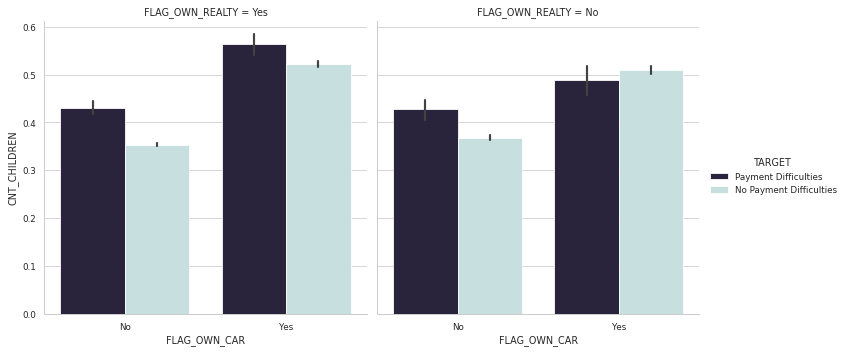

In [86]:
#Multivariat Visualization
sns.catplot(x = 'FLAG_OWN_CAR',
            y = 'CNT_CHILDREN', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)
plt.show()

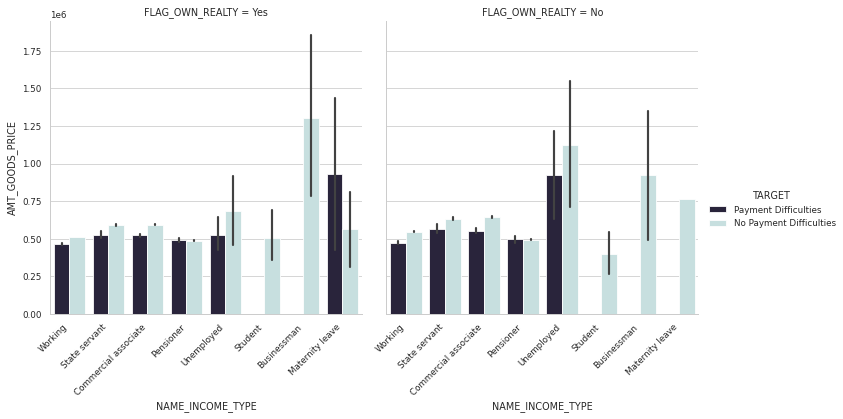

In [87]:
#Income Type, Amount of Goods Price, Target, and House/Flat Ownership Status
fig = sns.catplot(x = 'NAME_INCOME_TYPE',
            y = 'AMT_GOODS_PRICE', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

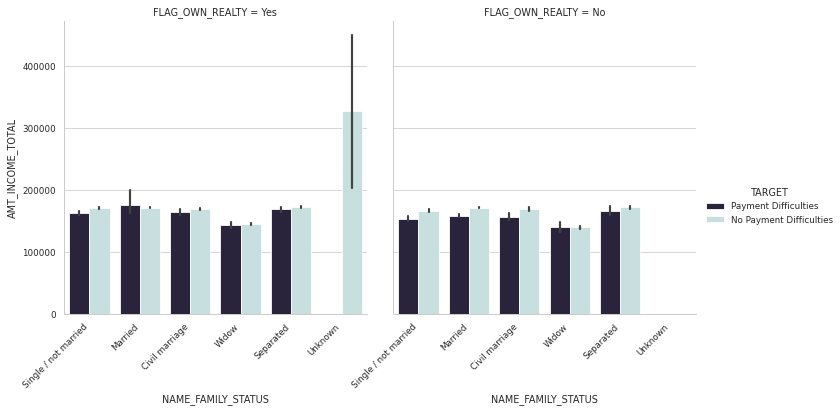

In [88]:
#Family Status, Amount of Income, Target, and House/Flat Ownership Status
fig = sns.catplot(x = 'NAME_FAMILY_STATUS',
            y = 'AMT_INCOME_TOTAL', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

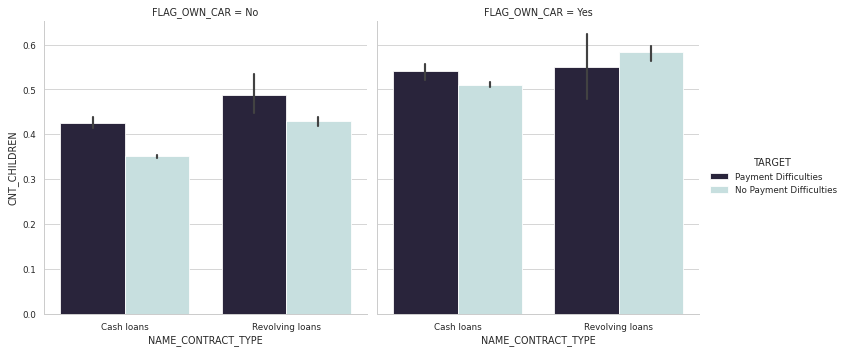

In [89]:
#Grouped by Car Ownership Status
sns.catplot(x = 'NAME_CONTRACT_TYPE',
            y = 'CNT_CHILDREN', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_CAR', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)
plt.show()

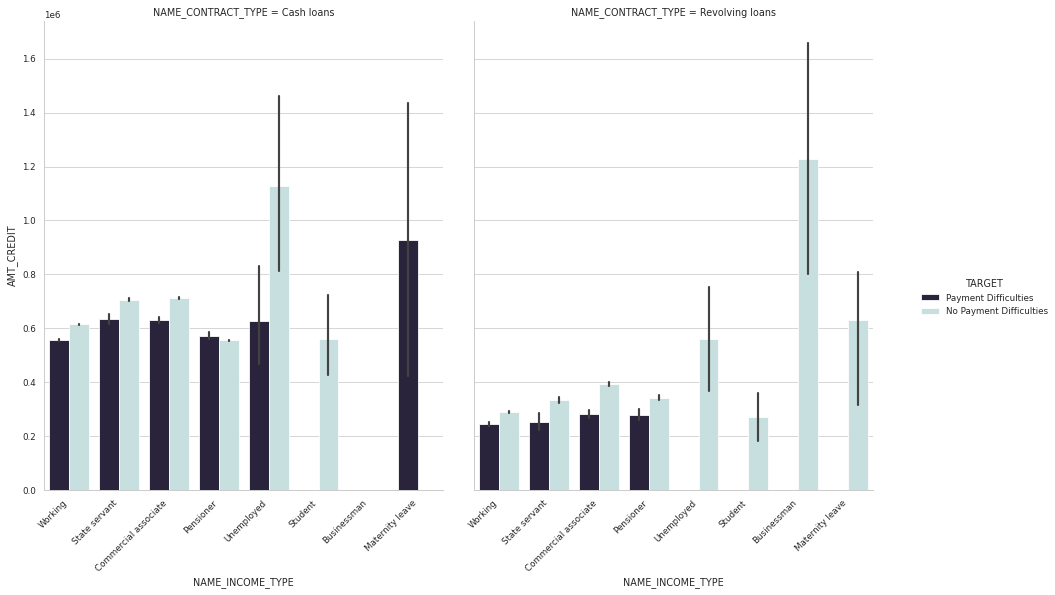

In [90]:
#Grouped by Contract Type
fig = sns.catplot(x = 'NAME_INCOME_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'NAME_CONTRACT_TYPE', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.gcf().set_size_inches(15, 8)
plt.show()


In [91]:
train.groupby(by=['NAME_INCOME_TYPE','NAME_CONTRACT_TYPE', 'TARGET'], as_index=False)['SK_ID_CURR'].count()

,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,TARGET,SK_ID_CURR
0,Businessman,Revolving loans,No Payment Difficulties,10
1,Commercial associate,Cash loans,No Payment Difficulties,58662
2,Commercial associate,Cash loans,Payment Difficulties,4990
3,Commercial associate,Revolving loans,No Payment Difficulties,7595
4,Commercial associate,Revolving loans,Payment Difficulties,370
5,Maternity leave,Cash loans,Payment Difficulties,2
6,Maternity leave,Revolving loans,No Payment Difficulties,3
7,Pensioner,Cash loans,No Payment Difficulties,49151
8,Pensioner,Cash loans,Payment Difficulties,2842
9,Pensioner,Revolving loans,No Payment Difficulties,3229


In [92]:
train.groupby(by=['NAME_INCOME_TYPE','NAME_CONTRACT_TYPE', 'TARGET'], as_index=False)['AMT_CREDIT'].mean()

,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,TARGET,AMT_CREDIT
0,Businessman,Revolving loans,No Payment Difficulties,1.228500e+06
1,Commercial associate,Cash loans,No Payment Difficulties,7.114464e+05
2,Commercial associate,Cash loans,Payment Difficulties,6.315081e+05
3,Commercial associate,Revolving loans,No Payment Difficulties,3.933160e+05
4,Commercial associate,Revolving loans,Payment Difficulties,2.806419e+05
5,Maternity leave,Cash loans,Payment Difficulties,9.292500e+05
6,Maternity leave,Revolving loans,No Payment Difficulties,6.300000e+05
7,Pensioner,Cash loans,No Payment Difficulties,5.547979e+05
8,Pensioner,Cash loans,Payment Difficulties,5.718242e+05
9,Pensioner,Revolving loans,No Payment Difficulties,3.417436e+05


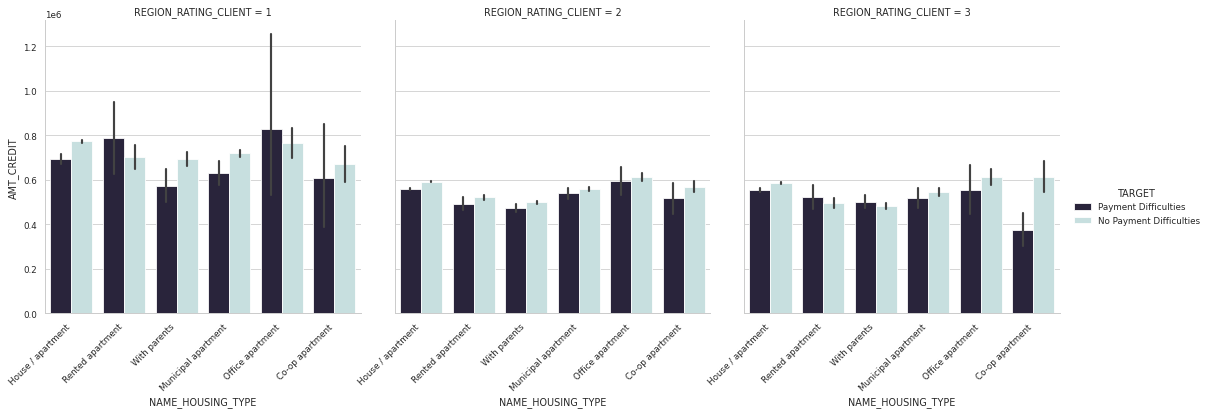

In [93]:
#Grouped by Rating of Region where Client Lives
fig = sns.catplot(x = 'NAME_HOUSING_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

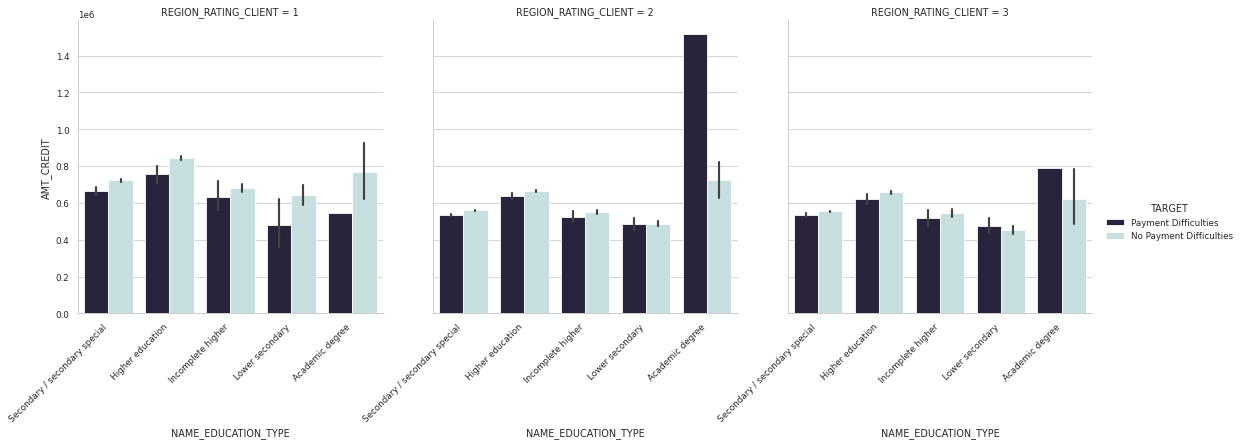

In [94]:
fig = sns.catplot(x = 'NAME_EDUCATION_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

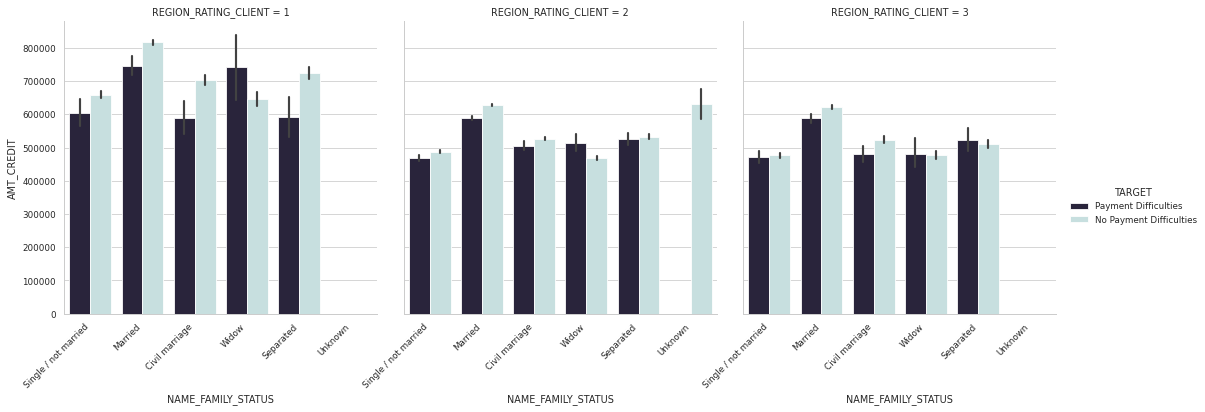

In [95]:
#Family Status, Amount Credit of Loan, Target, and Rating of Region where Client Lives
fig = sns.catplot(x = 'NAME_FAMILY_STATUS',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [96]:
train.groupby(by=['NAME_FAMILY_STATUS','REGION_RATING_CLIENT', 'TARGET'], as_index=False)['AMT_CREDIT'].mean()

,NAME_FAMILY_STATUS,REGION_RATING_CLIENT,TARGET,AMT_CREDIT
0,Civil marriage,1,No Payment Difficulties,704262.697373
1,Civil marriage,1,Payment Difficulties,588802.878505
2,Civil marriage,2,No Payment Difficulties,526937.803789
3,Civil marriage,2,Payment Difficulties,505484.586757
4,Civil marriage,3,No Payment Difficulties,523428.888809
5,Civil marriage,3,Payment Difficulties,480621.577434
6,Married,1,No Payment Difficulties,816876.580226
7,Married,1,Payment Difficulties,746928.141475
8,Married,2,No Payment Difficulties,628332.588727
9,Married,2,Payment Difficulties,588365.572898


In [97]:
#Data Cleaning
#Detecting Data Duplication
print('The number of duplication is:', application_train.duplicated().sum())


The number of duplication is: 0


In [100]:
# check for empty elements
print('Missing values status:', application_train.isnull().values.any())
nvc = pd.DataFrame(application_train.isnull().sum(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/application_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,COMMONAREA_MEDI,214865,69.872297
1,COMMONAREA_AVG,214865,69.872297
2,COMMONAREA_MODE,214865,69.872297
3,NONLIVINGAPARTMENTS_MODE,213514,69.432963
4,NONLIVINGAPARTMENTS_AVG,213514,69.432963
...,...,...,...
117,NAME_HOUSING_TYPE,0,0.000000
118,NAME_FAMILY_STATUS,0,0.000000
119,NAME_EDUCATION_TYPE,0,0.000000
120,NAME_INCOME_TYPE,0,0.000000


In [102]:

# drop features that have large number of missing values (± 50%)
application_train.drop(application_train.iloc[:, 44:91], inplace=True, axis=1)
application_train.drop(['OWN_CAR_AGE','EXT_SOURCE_1'], inplace=True, axis=1)

In [103]:
# after drop some features
print('Missing values status:', application_train.isnull().values.any())
nvc = pd.DataFrame(application_train.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/application_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,OCCUPATION_TYPE,96391,31.345545
1,EXT_SOURCE_3,60965,19.825307
2,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.501631
3,AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.501631
4,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.501631
...,...,...,...
68,FLAG_DOCUMENT_18,0,0.000000
69,FLAG_DOCUMENT_17,0,0.000000
70,FLAG_DOCUMENT_16,0,0.000000
71,FLAG_DOCUMENT_15,0,0.000000


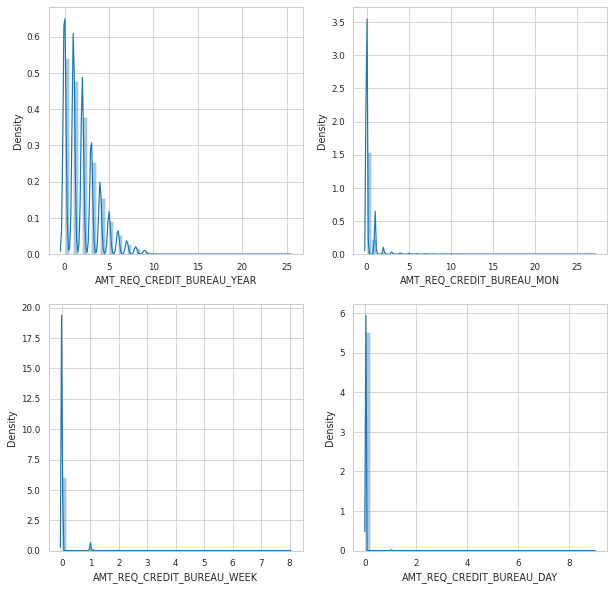

In [105]:
# distribution of numerical features that have missing values pt.1
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(application_train['AMT_REQ_CREDIT_BUREAU_YEAR'], ax=ax[0][0])

sns.distplot(application_train['AMT_REQ_CREDIT_BUREAU_MON'], ax=ax[0][1])

sns.distplot(application_train['AMT_REQ_CREDIT_BUREAU_WEEK'], ax=ax[1][0])

sns.distplot(application_train['AMT_REQ_CREDIT_BUREAU_DAY'], ax=ax[1][1])

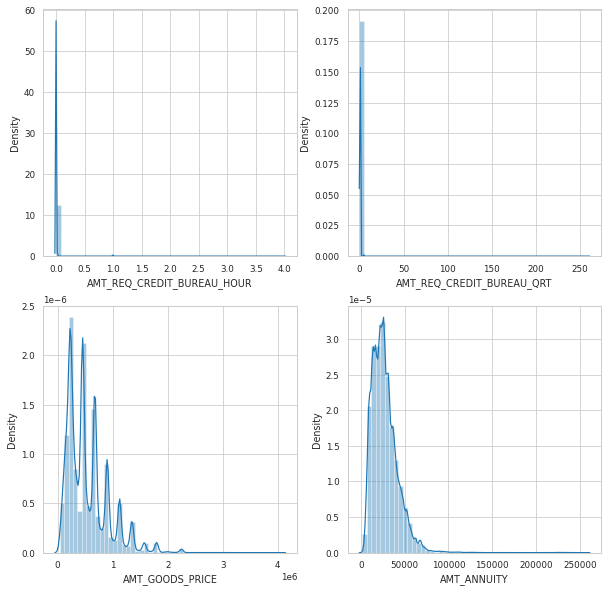

In [106]:
# distribution of numerical features that have missing values pt.2
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(application_train['AMT_REQ_CREDIT_BUREAU_HOUR'], ax=ax[0][0])

sns.distplot(application_train ['AMT_REQ_CREDIT_BUREAU_QRT'], ax=ax[0][1])

sns.distplot(application_train['AMT_GOODS_PRICE'], ax=ax[1][0])

sns.distplot(application_train['AMT_ANNUITY'], ax=ax[1][1])

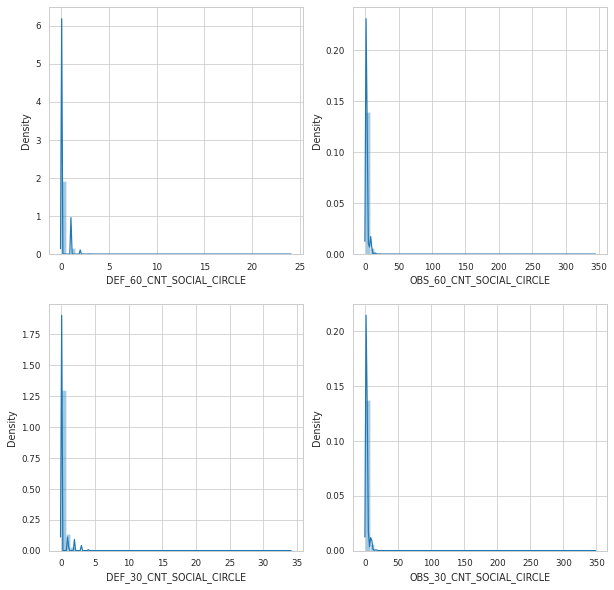

In [107]:
# distribution of numerical features that have missing values pt.3
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(application_train['DEF_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][0])

sns.distplot(application_train['OBS_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][1])

sns.distplot(application_train['DEF_30_CNT_SOCIAL_CIRCLE'], ax=ax[1][0])

sns.distplot(application_train['OBS_30_CNT_SOCIAL_CIRCLE'], ax=ax[1][1])

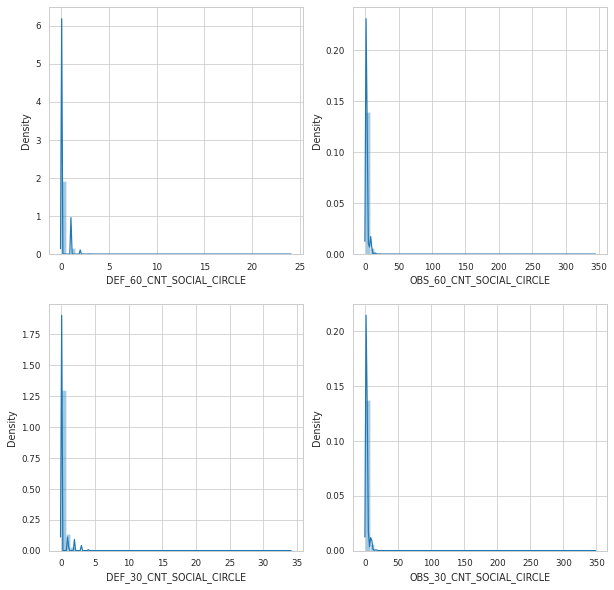

In [108]:
# distribution of numerical features that have missing values pt.3
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(application_train['DEF_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][0])

sns.distplot(application_train['OBS_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][1])

sns.distplot(application_train['DEF_30_CNT_SOCIAL_CIRCLE'], ax=ax[1][0])

sns.distplot(application_train['OBS_30_CNT_SOCIAL_CIRCLE'], ax=ax[1][1])

In [110]:
# impute missing values with median because the data is skewed for numerical features
# impute missing values with mode for categorical features

category_columns = application_train.select_dtypes(include=['object']).columns.tolist()
integer_columns = application_train.select_dtypes(include=['int64','float64']).columns.tolist()

for column in application_train:
    if application_train[column].isnull().any():
        if(column in category_columns):
            application_train[column]=application_train[column].fillna(application_train[column].mode()[0])
        else:
            application_train[column]=application_train[column].fillna(application_train[column].median())

In [111]:
# after imputation
print('Missing values status:', application_train.isnull().values.any())
print('\nThe number of missing values for each columns (after imputation): \n')
nvc = pd.DataFrame(application_train.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/application_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: False

The number of missing values for each columns (after imputation): 



,index,Total Null Values,Percentage
0,SK_ID_CURR,0,0.0
1,REG_REGION_NOT_WORK_REGION,0,0.0
2,REGION_POPULATION_RELATIVE,0,0.0
3,AMT_INCOME_TOTAL,0,0.0
4,TARGET,0,0.0
...,...,...,...
68,FLAG_DOCUMENT_20,0,0.0
69,FLAG_DOCUMENT_21,0,0.0
70,AMT_REQ_CREDIT_BUREAU_HOUR,0,0.0
71,AMT_REQ_CREDIT_BUREAU_DAY,0,0.0


In [112]:
# dataset that only consist numerical features pt.1
int_features = application_train[["CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]]

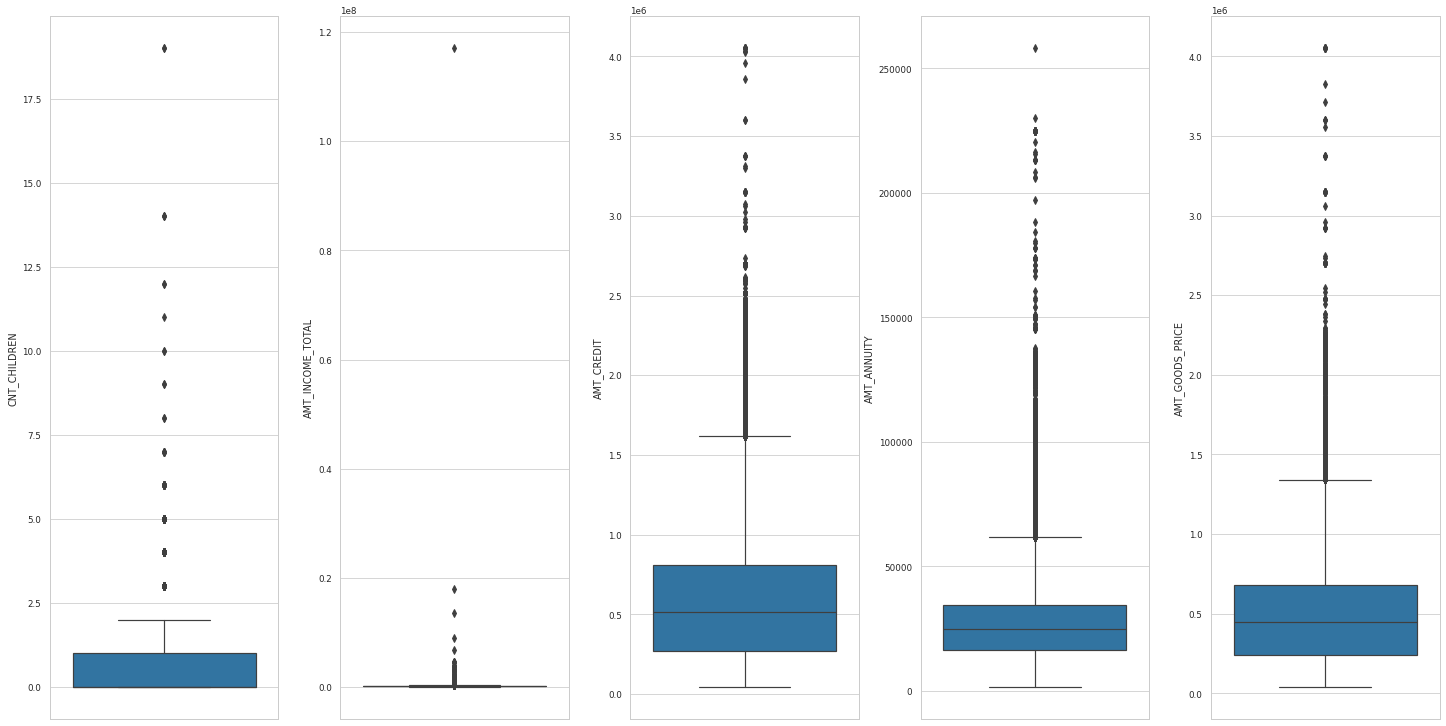

In [113]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [114]:
# dataset that only consist numerical features pt.2
int_features = application_train[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "CNT_FAM_MEMBERS"]]

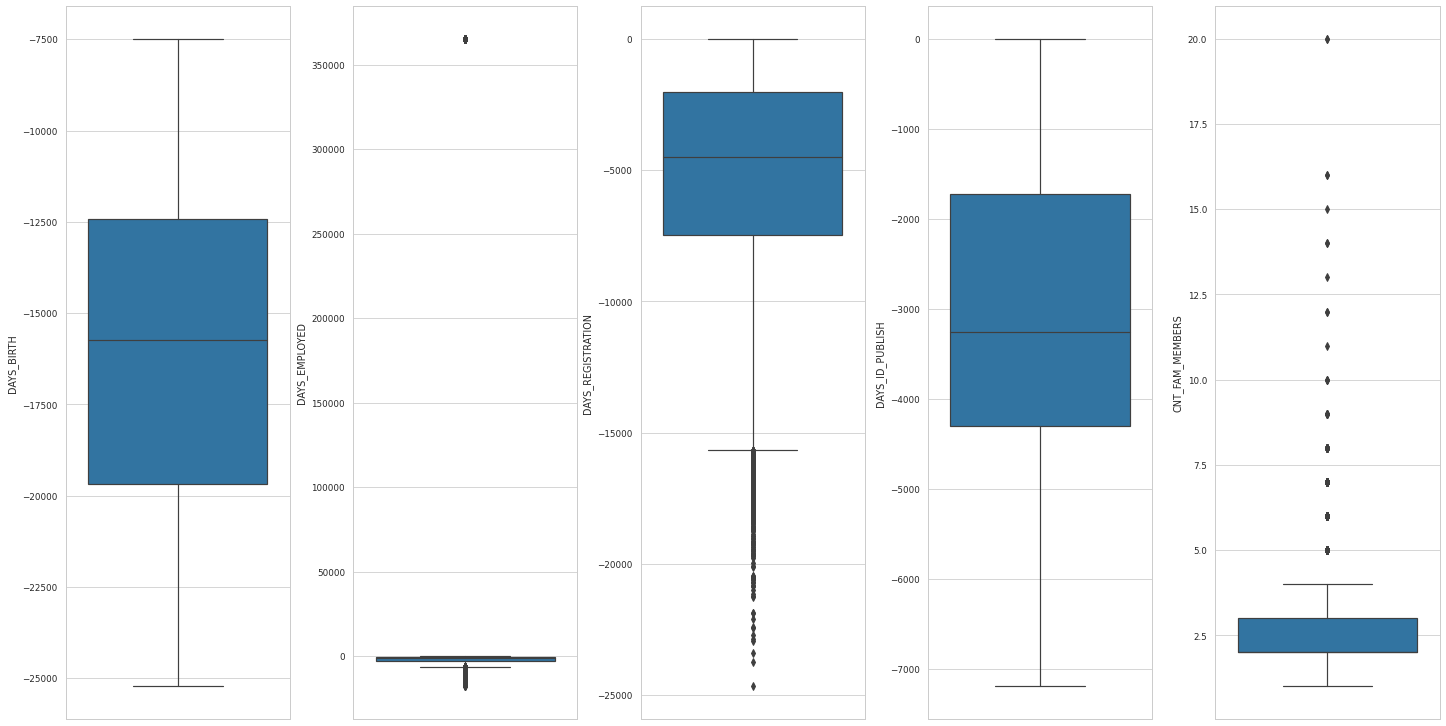

In [115]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [119]:
# dataset that only consist numerical features pt.3
int_features = application_train[["AMT_REQ_CREDIT_BUREAU_YEAR", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_HOUR"]]


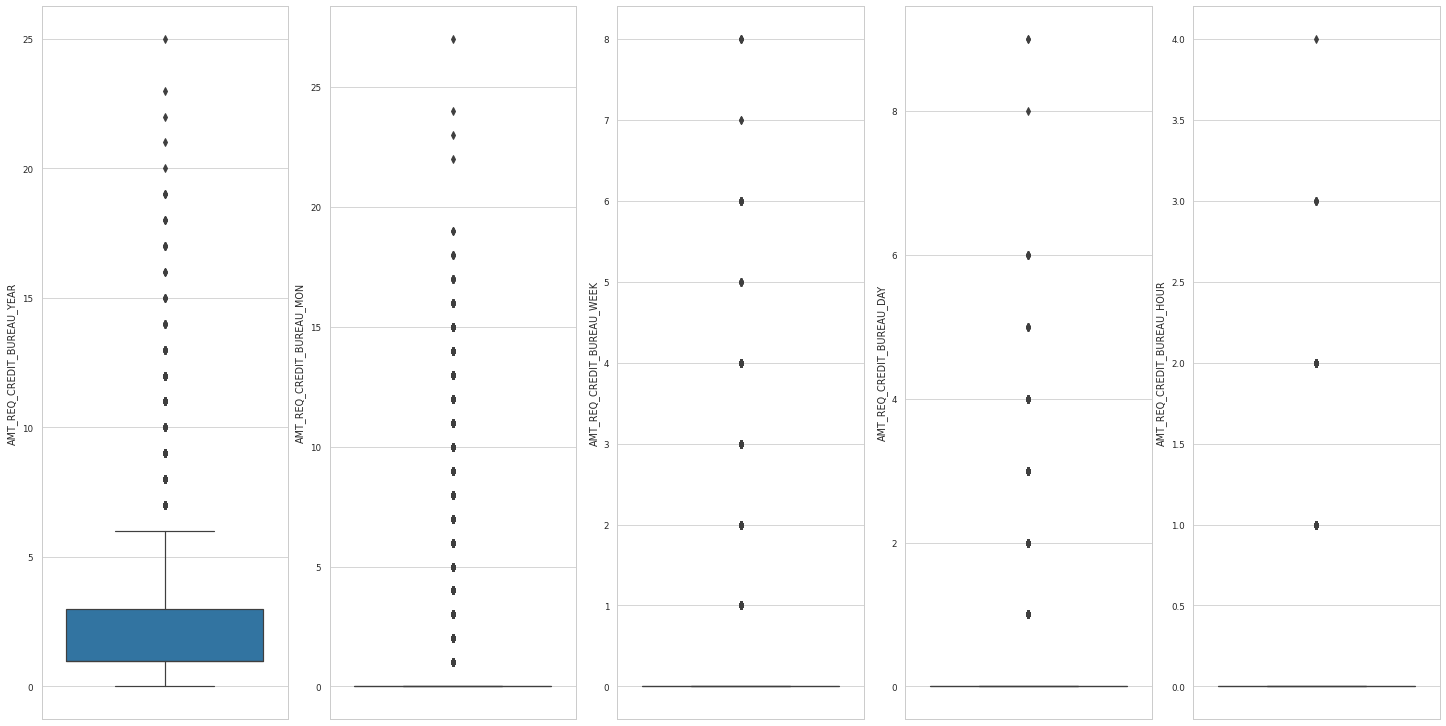

In [120]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [122]:
# dataset that only consist numerical features pt.4
int_features = application_train[["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "REGION_POPULATION_RELATIVE"]]


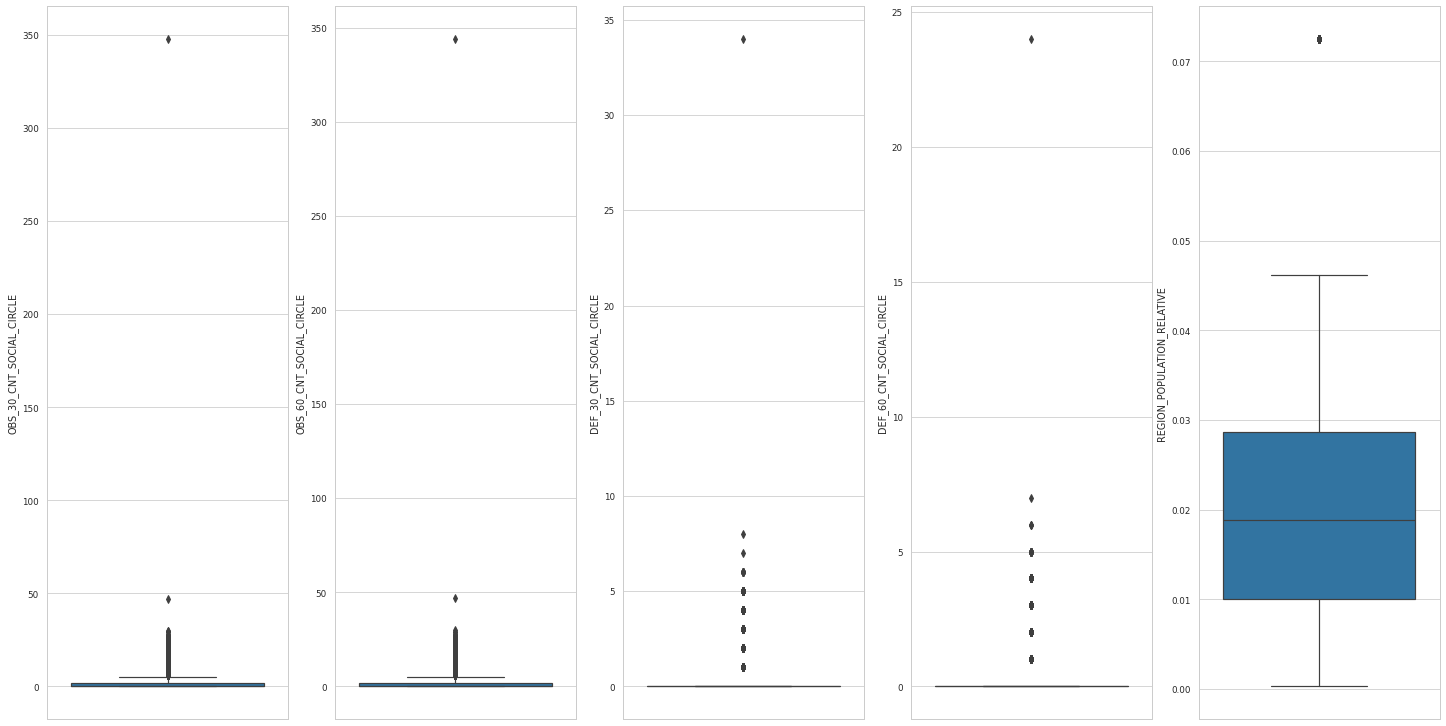

In [123]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [124]:
# dataset that only consist numerical features pt.5
int_features = application_train[["REGION_RATING_CLIENT", "HOUR_APPR_PROCESS_START", "DAYS_LAST_PHONE_CHANGE", "FLAG_DOCUMENT_2", "AMT_REQ_CREDIT_BUREAU_QRT"]]


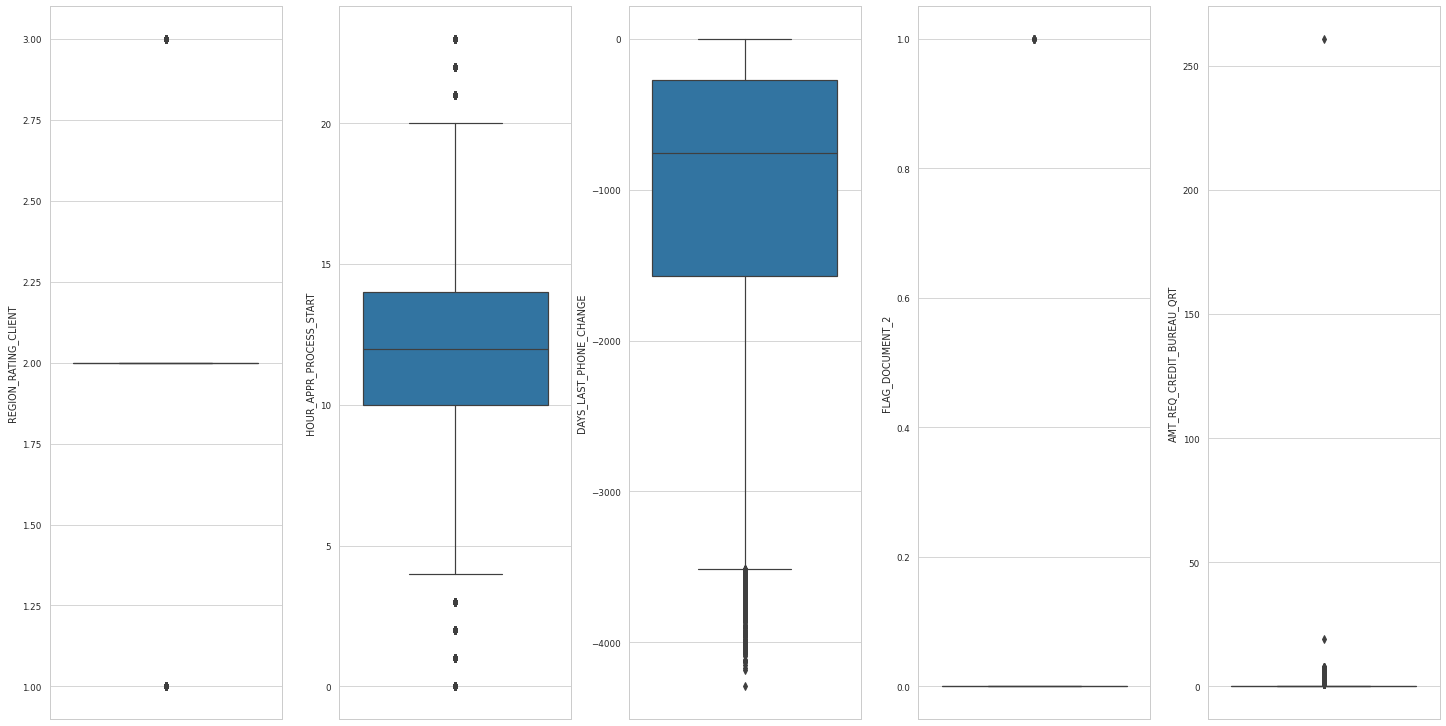

In [125]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [126]:
#Machine Learning Models
#Label Encoding
# label encoder for object features
application_train[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = application_train[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)

In [127]:
application_train.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
#Feature Selection
#Drop Unnecessary Feature
application_train.drop(['SK_ID_CURR'], inplace=True, axis=1)
application_train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
#Convert Negative Values to Positive Values
#The features that have negative values are DAYS_BIRTH, DAYS_EMPLOYED, DAYS_ID_PUBLISH, DAYS_REGISTRATION, and DAYS_LAST_PHONE_CHANGE

application_train.iloc[:,16:20] = application_train.iloc[:,16:20].abs()
application_train.iloc[:,45] = application_train.iloc[:,45].abs()

In [130]:
x = application_train.drop(['TARGET'], axis=1)
y = application_train['TARGET']

In [131]:
# feature selection
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']
print('The features that correlate well with target feature:\n')
featureScores.sort_values(by=['Score'], ascending=False)

The features that correlate well with target feature:



,Features,Score
16,DAYS_EMPLOYED,1.954124e+08
8,AMT_GOODS_PRICE,1.223080e+08
6,AMT_CREDIT,7.669987e+07
15,DAYS_BIRTH,2.235391e+06
5,AMT_INCOME_TOTAL,1.624102e+06
...,...,...
48,FLAG_DOCUMENT_5,3.020010e-02
63,FLAG_DOCUMENT_20,1.425955e-02
65,AMT_REQ_CREDIT_BUREAU_HOUR,1.832008e-03
22,FLAG_CONT_MOBILE,7.863447e-05


In [132]:
#Handling Data Imbalance
# create two different dataframe of majority and minority class 
df_majority = application_train[(application_train['TARGET']==0)] 
df_minority = application_train[(application_train['TARGET']==1)] 

# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 282686, # to match majority class
                                 random_state=42)  # reproducible results

# combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

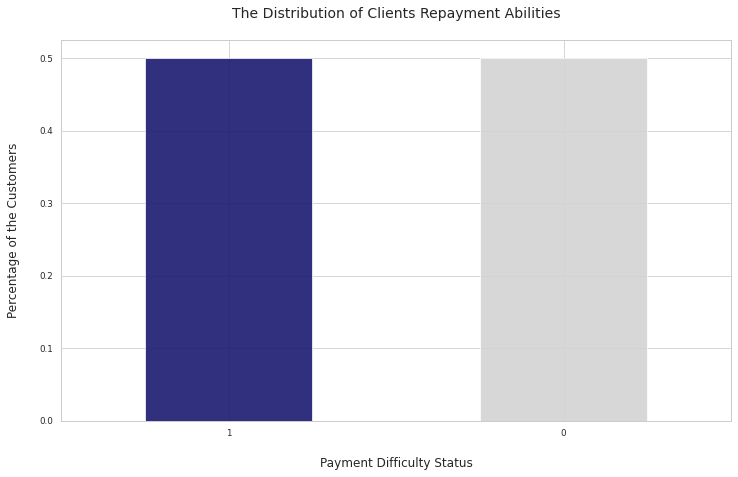

In [133]:
fig = plt.figure(figsize = (12,7))
df_upsampled['TARGET'].value_counts(normalize=True).plot(kind='bar', color= ['midnightblue','lightgrey'], alpha = 0.9, rot=0)
plt.title('The Distribution of Clients Repayment Abilities\n', fontsize=14)
plt.ylabel('Percentage of the Customers\n', fontsize=12)
plt.xlabel('\nPayment Difficulty Status', fontsize=12)
plt.show()

In [134]:
# define x and y features (top 20 features)
x_balanced = df_upsampled[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 
                           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION', 
                           'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 
                           'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
                          'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE',
                          'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
y_balanced = df_upsampled['TARGET']

In [135]:
# splitting tha data
X_train, X_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(452297, 20) (113075, 20)


In [136]:
# normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [137]:
#Model Building
#Logistic Regression
# train the model
log_model = LogisticRegression().fit(X_train, y_train)
print(log_model)

LogisticRegression()


In [138]:
# predict data train
y_train_pred_log = log_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Logistic Regression):')
print(classification_report(y_train, y_train_pred_log))

Classification Report Training Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68    226185
           1       0.68      0.66      0.67    226112

    accuracy                           0.67    452297
   macro avg       0.67      0.67      0.67    452297
weighted avg       0.67      0.67      0.67    452297



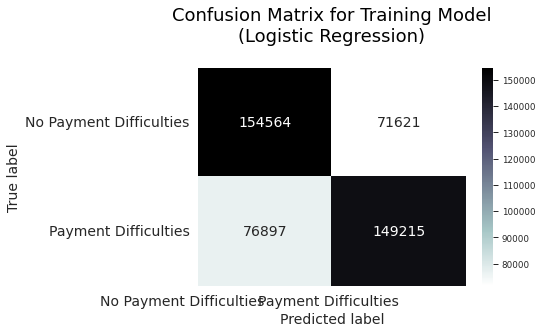

In [139]:
# form confusion matrix as a dataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_train, y_train_pred_log)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [140]:
# predict data test
y_test_pred_log = log_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (Logistic Regression):')
print(classification_report(y_test, y_test_pred_log))

Classification Report Testing Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68     56501
           1       0.68      0.66      0.67     56574

    accuracy                           0.67    113075
   macro avg       0.67      0.67      0.67    113075
weighted avg       0.67      0.67      0.67    113075



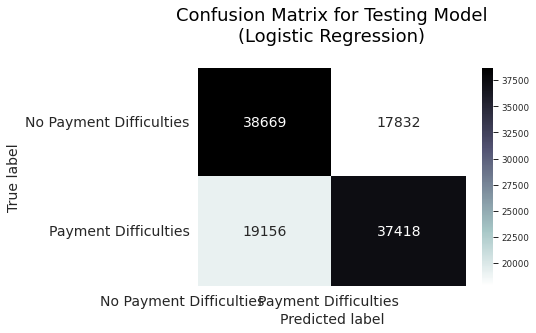

In [141]:
# form confusion matrix as a dataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_test, y_test_pred_log)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [142]:
acc_log_train=round(log_model.score(X_train,y_train)*100,2)
acc_log_test=round(log_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Test Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 67.16
Test Accuracy: % 67.29


In [143]:
# ROC scores
roc_auc_log = round(roc_auc_score(y_test, y_test_pred_log),4)
print('ROC AUC:', roc_auc_log)

ROC AUC: 0.6729


In [145]:
# train the model
#decision tree
dt_model = DecisionTreeClassifier().fit(X_train,y_train)
print(dt_model)


DecisionTreeClassifier()


In [146]:
# predict data train
y_train_pred_dt = dt_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Decision Tree Classifier):')
print(classification_report(y_train, y_train_pred_dt))

Classification Report Training Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226185
           1       1.00      1.00      1.00    226112

    accuracy                           1.00    452297
   macro avg       1.00      1.00      1.00    452297
weighted avg       1.00      1.00      1.00    452297



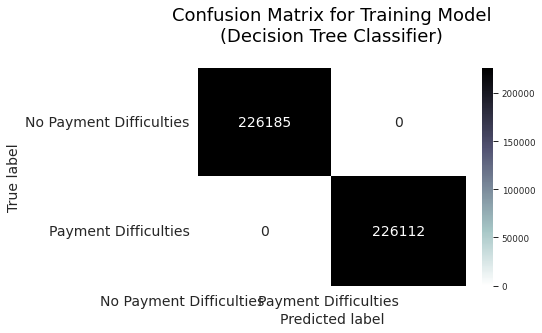

In [147]:
# form confusion matrix as a dataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_train, y_train_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Decision Tree Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [148]:
# predict data test
y_test_pred_dt = dt_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (Decision Tree Classifier):')
print(classification_report(y_test, y_test_pred_dt))

Classification Report Testing Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       0.87      0.91      0.88     56501
           1       0.90      0.86      0.88     56574

    accuracy                           0.88    113075
   macro avg       0.88      0.88      0.88    113075
weighted avg       0.88      0.88      0.88    113075



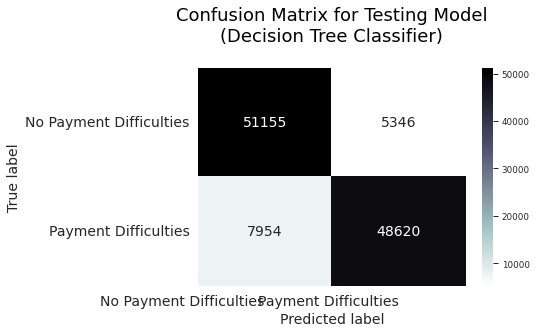

In [149]:
# form confusion matrix as a dataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_test, y_test_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Decision Tree Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [150]:
acc_dt_train=round(dt_model.score(X_train,y_train)*100,2)
acc_dt_test=round(dt_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_dt_train))
print("Test Accuracy: % {}".format(acc_dt_test))

Training Accuracy: % 100.0
Test Accuracy: % 88.24


In [151]:
# ROC scores
roc_auc_dt = round(roc_auc_score(y_test, y_test_pred_dt),4)
print('ROC AUC:', roc_auc_dt)

ROC AUC: 0.8824


In [153]:
#Random Forest
# train the model
rf_model = RandomForestClassifier().fit(X_train, y_train)
print(rf_model)

RandomForestClassifier()


In [154]:
# predict data train
y_train_pred_dt = rf_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Decision Tree Classifier):')
print(classification_report(y_train, y_train_pred_dt))

Classification Report Training Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226185
           1       1.00      1.00      1.00    226112

    accuracy                           1.00    452297
   macro avg       1.00      1.00      1.00    452297
weighted avg       1.00      1.00      1.00    452297



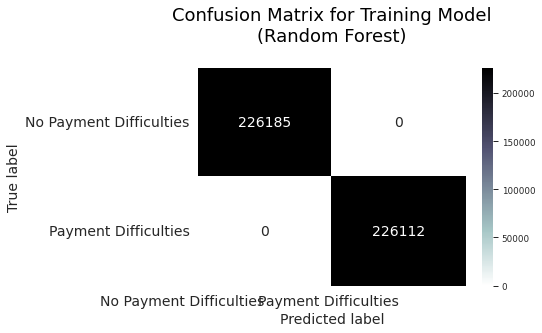

In [155]:
# form confusion matrix as a dataFrame
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_train, y_train_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Random Forest)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [156]:
# predict data test
y_test_pred_rf = rf_model.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report

# print classification report
print('Classification Report Testing Model (Random Forest Classifier):')
print(classification_report(y_test, y_test_pred_rf))

Classification Report Testing Model (Random Forest Classifier):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56501
           1       0.99      1.00      1.00     56574

    accuracy                           1.00    113075
   macro avg       1.00      1.00      1.00    113075
weighted avg       1.00      1.00      1.00    113075



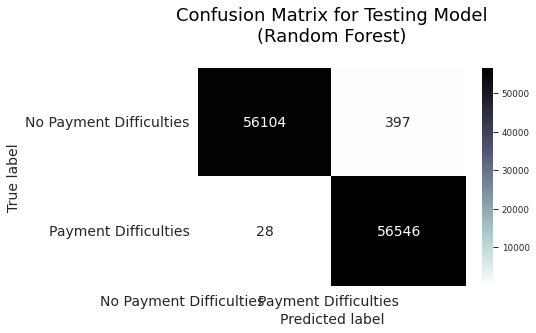

In [157]:
# form confusion matrix as a dataFrame
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_test, y_test_pred_rf)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Random Forest)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [158]:
acc_rf_train=round(rf_model.score(X_train,y_train)*100,2)
acc_rf_test=round(rf_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_rf_train))
print("Test Accuracy: % {}".format(acc_rf_test))

Training Accuracy: % 100.0
Test Accuracy: % 99.62


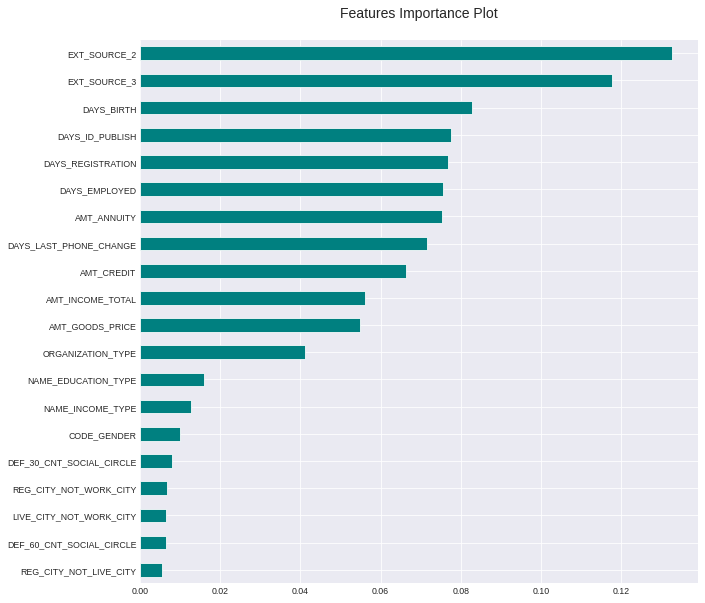

In [159]:
# important features
importances_rf = pd.Series(rf_model.feature_importances_, index=x_balanced.columns).sort_values(ascending=True)

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,10))
fig = importances_rf.plot(kind ='barh', color ='teal')
plt.title('Features Importance Plot\n', fontsize=14)
plt.show()

fig.figure.tight_layout()
fig.figure.savefig('top feature.png')

In [163]:

results = pd.DataFrame([["Logistic Regression", 0.6716, 0.6729, 0.6729],
                       ["Decision Tree", 1, 0.8826, 0.8826],["Random Forest", 1, 0.9965, 0.9965]],
                      
                        columns = ["Models", "Training Accuracy Score", "Testing Accuracy Score", "ROC Score"])

results.sort_values(by=['Training Accuracy Score', 'Testing Accuracy Score'], ascending=False).style.background_gradient(cmap='Blues')

,Models,Training Accuracy Score,Testing Accuracy Score,ROC Score
2,Random Forest,1.000000,0.996500,0.996500
1,Decision Tree,1.000000,0.882600,0.882600
0,Logistic Regression,0.671600,0.672900,0.672900


In [164]:
#Prediction
#Import Dataset
# data application (test)
application_test = pd.read_csv("sample_data/application_test.csv")
print('This dataset has %d rows dan %d columns.\n' % application_test.shape)
application_test.head()

This dataset has 48744 rows dan 121 columns.



,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
print('The number of duplication is:', application_test.duplicated().sum())
# there is no duplication


The number of duplication is: 0


In [166]:
#Detecting Missing Values
# check for empty elements
print('Missing values status:', application_test.isnull().values.any())
tvc = pd.DataFrame(application_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/application_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,COMMONAREA_AVG,33495,68.716150
1,COMMONAREA_MODE,33495,68.716150
2,COMMONAREA_MEDI,33495,68.716150
3,NONLIVINGAPARTMENTS_AVG,33347,68.412523
4,NONLIVINGAPARTMENTS_MODE,33347,68.412523
...,...,...,...
116,NAME_HOUSING_TYPE,0,0.000000
117,NAME_FAMILY_STATUS,0,0.000000
118,NAME_EDUCATION_TYPE,0,0.000000
119,NAME_INCOME_TYPE,0,0.000000


In [167]:
# drop features that have large number of missing values (± 50%)
application_test.drop(application_test.iloc[:, 43:90], inplace=True, axis=1)
application_test.drop(['OWN_CAR_AGE','EXT_SOURCE_1'], inplace=True, axis=1)

In [168]:
# after drop some features
print('Missing values status:', application_test.isnull().values.any())
tvc = pd.DataFrame(application_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/application_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,OCCUPATION_TYPE,15605,32.014197
1,EXT_SOURCE_3,8668,17.782701
2,AMT_REQ_CREDIT_BUREAU_YEAR,6049,12.409732
3,AMT_REQ_CREDIT_BUREAU_QRT,6049,12.409732
4,AMT_REQ_CREDIT_BUREAU_MON,6049,12.409732
...,...,...,...
67,REG_REGION_NOT_LIVE_REGION,0,0.000000
68,REG_REGION_NOT_WORK_REGION,0,0.000000
69,LIVE_REGION_NOT_WORK_REGION,0,0.000000
70,REG_CITY_NOT_LIVE_CITY,0,0.000000


In [170]:
# impute missing values with median because the data is skewed for numerical features
# impute missing values with mode for categorical features

category_columns = application_test.select_dtypes(include=['object']).columns.tolist()
integer_columns = application_test.select_dtypes(include=['int64','float64']).columns.tolist()

for column in application_test:
    if application_test[column].isnull().any():
        if(column in category_columns):
            application_test[column]=application_test[column].fillna(application_test[column].mode()[0])
        else:
            application_test[column]=application_test[column].fillna(application_test[column].median())

In [171]:
# after imputation
print('Missing values status:', application_test.isnull().values.any())
tvc = pd.DataFrame(application_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/application_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: False


,index,Total Null Values,Percentage
0,SK_ID_CURR,0,0.0
1,NAME_CONTRACT_TYPE,0,0.0
2,FLAG_DOCUMENT_8,0,0.0
3,FLAG_DOCUMENT_7,0,0.0
4,FLAG_DOCUMENT_6,0,0.0
...,...,...,...
67,FLAG_CONT_MOBILE,0,0.0
68,FLAG_WORK_PHONE,0,0.0
69,FLAG_EMP_PHONE,0,0.0
70,FLAG_MOBIL,0,0.0


In [173]:
# label encoder for object features
application_test[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = application_test[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)

In [174]:
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [175]:
#Convert Negative Values to Positive Values
#The features that have negative values are DAYS_BIRTH, DAYS_EMPLOYED, DAYS_ID_PUBLISH, and DAYS_REGISTRATION, DAYS_LAST_PHONE_CHANGE

application_test.iloc[:,16:20] = application_test.iloc[:,16:20].abs()
application_test.iloc[:,45] = application_test.iloc[:,45].abs()

In [ ]:
#Prediction
Predict client's repayment abilities on application data test with best machine learning model obtained before, i.e Random Forest.

In [177]:
pred_test = application_test[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 
'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION', 
'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 
'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE','DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
pred_test.head()


,DAYS_EMPLOYED,AMT_GOODS_PRICE,AMT_CREDIT,DAYS_BIRTH,AMT_INCOME_TOTAL,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,AMT_ANNUITY,ORGANIZATION_TYPE,NAME_INCOME_TYPE,REG_CITY_NOT_WORK_CITY,CODE_GENDER,EXT_SOURCE_2,REG_CITY_NOT_LIVE_CITY,NAME_EDUCATION_TYPE,DEF_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_3,DEF_60_CNT_SOCIAL_CIRCLE,LIVE_CITY_NOT_WORK_CITY
0,2329,450000.0,568800.0,19241,135000.0,5170.0,1740.0,812,20560.5,28,6,0,0,0.789654,0,1,0.0,0.159520,0.0,0
1,4469,180000.0,222768.0,18064,99000.0,9118.0,0.0,1623,17370.0,42,6,0,1,0.291656,0,4,0.0,0.432962,0.0,0
2,4458,630000.0,663264.0,20038,202500.0,2175.0,856.0,3503,69777.0,54,6,0,1,0.699787,0,1,0.0,0.610991,0.0,0
3,1866,1575000.0,1575000.0,13976,315000.0,2000.0,1805.0,4208,49018.5,5,6,0,0,0.509677,0,4,0.0,0.612704,0.0,0
4,2191,625500.0,625500.0,13040,180000.0,4000.0,821.0,4262,32067.0,5,6,1,1,0.425687,0,4,0.0,0.519097,0.0,1


In [179]:
# lets predict!
predict = pd.Series(rf_model.predict(pred_test), name = "TARGET").astype(int)
results = pd.concat([application_test['SK_ID_CURR'], predict],axis = 1)
results.to_csv("predict application.csv", index = False)
results.head()

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0
